In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from procyon.data.data_utils import DATA_DIR

Cost can be a concern when comparing ProCyon models to external LLMs such as GPT-4o or Mistral Large due to the large size of ProCyon-Instruct and the potentially long text length of generated phenotypes. Thus we elected to subset the proteins considered for LLM comparison to a smaller set that still represents the variance in knowledge about human proteins.

This notebook was used to perform subsampling of datasets of interest, stratified by [UniProt annotation scores](https://www.uniprot.org/help/annotation_score).

In [3]:
# Directory containing UniProt annotation scores and where the output containing selected samples will be written.
path = os.path.join(
    DATA_DIR,
    "experimental_data",
    "llm_judge_eval",
    "selected_caption_samples",
)
annot_scores_path = os.path.join(
    path,
    "uniprotkb_proteome_UP000005640_2024_06_18.tsv.gz",
)

# Load annotation scores

In [4]:
# Load in TSV exported from UniProt containing all UniProt human proteins and their associated
# annotation scores.
annot_scores = pd.read_table(annot_scores_path).assign(
    num_pubs=lambda x: np.where(
        x["PubMed ID"].isna(), 0, (x["PubMed ID"].str.count(";") + 1)
    ).astype(int),
)
annot_scores.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Length,Annotation,PubMed ID,num_pubs
0,A0A075B6G3,unreviewed,A0A075B6G3_HUMAN,Dystrophin,DMD,3685,5.0,15772651; 17081983; 18669648; 19413330; 200682...,9
1,A0A087WV00,unreviewed,A0A087WV00_HUMAN,Diacylglycerol kinase (DAG kinase) (EC 2.7.1.107),DGKI,1057,5.0,12853948,1
2,A0A087WXI3,unreviewed,A0A087WXI3_HUMAN,Fragile X messenger ribonucleoprotein 1,FMR1,536,5.0,15772651; 20068231; 21269460; 22814378; 24275569,5
3,A0A087WY29,unreviewed,A0A087WY29_HUMAN,Fragile X messenger ribonucleoprotein 1,FMR1,561,5.0,15772651; 21269460; 22814378; 24275569,4
4,A0A087WZT3,unreviewed,A0A087WZT3_HUMAN,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6,44,5.0,15616553; 21269460,2


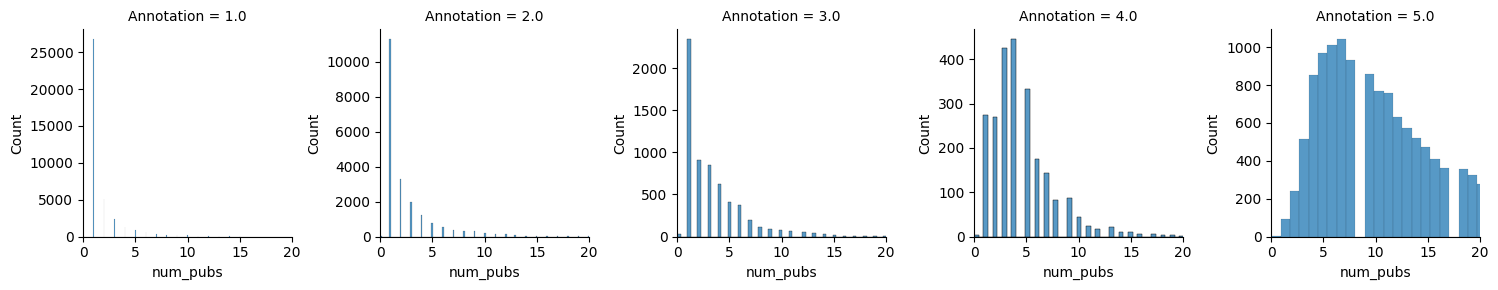

In [5]:
fg = sns.FacetGrid(data=annot_scores, col="Annotation", sharey=False, sharex=False)
fg.map_dataframe(sns.histplot, x="num_pubs")
fg.set(xlim=(0, 20))

# Annotation score by dataset

In [6]:
aaseq_info = pd.read_pickle(
    os.path.join(
        DATA_DIR,
        "integrated_data",
        "v1",
        "protein",
        "protein_info_filtered.pkl",
    )
)

relation2id = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "integrated_data",
        "v1",
        "relation2id.csv",
    )
)

In [7]:
aaseq_info = aaseq_info.merge(
    (annot_scores
     [["Entry", "Annotation", "num_pubs"]]
     .rename(columns={"Entry": "protein_id", "Annotation": "annotation_score"})
     .astype({"annotation_score": int})),
    on="protein_id"
)
aaseq_info.head()

,index,protein_id,name,entry,comments,annotation_score,num_pubs
0,0,P31946,YWHAB,1433B_HUMAN,['FUNCTION: Adapter protein implicated in the ...,5,41
1,1,P62258,YWHAE,1433E_HUMAN,['FUNCTION: Adapter protein implicated in the ...,5,44
2,2,Q04917,YWHAH,1433F_HUMAN,['FUNCTION: Adapter protein implicated in the ...,5,23
3,3,P61981,YWHAG,1433G_HUMAN,['FUNCTION: Adapter protein implicated in the ...,5,32
4,4,P31947,SFN,1433S_HUMAN,['FUNCTION: Adapter protein implicated in the ...,5,24


# Select samples for LLM comparisons

Main things to think about when we select samples to evaluate on per dataset are:
- UniProt annotation score -> want a decent spread across scores
- Number of relations, the number of annotations a protein has may affect the caption quality
  (ie. bias towards generalities), also makes it less tractable/more expensive to provide
  references to LLMs for LLM-as-a-judge ranking
- Dataset split. If the relation is in the train split. more likely that we'll get perfect
  evaluation metrics just by merit of memorizing train set, so probably want proteins 
  with relations mostly (or only?) in non-train splits.

Given the above, our strategy for subsampling will mostly focus on getting representation
across annotation scores. We'll use Disgenet, Reactome, and UniProt to ensure that
we get representation across knowledge domains. Within each dataset, we'll use all proteins with
an annotation score of 2 or 3, and then take up to 50 proteins from each of annotation scores 4 and 5.
When performing our subsampling, we'll set a cap on the number of relations a given
protein has (ideally less than 10).

In [8]:
canonical_splits = {
    "disgenet": "area_protein_aware_disgenet_centric",
    "drugbank": "atc_aware_drugbank_centric",
    "ec": "hierarchy_aware_ec_centric",
    "go": "sample_aware_ontology_go_centric",
    "omim": "disgenet_aligned_improved_omim_centric",
    "reactome": "random_reactome_centric",
    "uniprot": "random_uniprot_centric",
}


def get_rels(
    text_type: str,
) -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(
            DATA_DIR,
            "integrated_data",
            "v1",
            f"protein_{text_type}",
            canonical_splits[text_type],
            f"protein_{text_type}_relations_indexed.unified.csv",
        )
    )


def select_from_dataset(
    dataset_name: str,
    relation: str = "all",
    sample_num_high_score: int = 50,
    max_relations: int = 10,
    seed: int = 42,
) -> pd.DataFrame:
    dataset = get_rels(dataset_name)
    if relation != "all":
        relation_idx = relation2id.query("relation == @relation")
        assert len(relation_idx) == 1, f"got {relation_idx}"
        relation_idx = relation_idx["index"].iat[0]
        dataset = dataset.query("relation == @relation_idx")

    avail_proteins = (
        dataset.seq_id.value_counts()
        .reset_index()
        .rename(columns={"count": "num_relations"})
        .merge(aaseq_info, left_on="seq_id", right_on="index")
    )
    print(f"{dataset_name} {relation}: selecting from {len(avail_proteins)} proteins")

    selected_proteins = []
    for score, df in avail_proteins.groupby("annotation_score"):
        if score in [1, 2]:
            selected_proteins.append(df)
        else:
            subset = df.query("num_relations <= @max_relations")
            if len(subset) < sample_num_high_score:
                print(
                    f"{dataset_name} {relation}: score {score}, only {len(subset)} / {len(df)} proteins with fewer than {max_relations} relations"
                )
                this_num_to_sample = len(subset)
            else:
                this_num_to_sample = sample_num_high_score
            selected_proteins.append(
                subset.sample(n=this_num_to_sample, random_state=seed)
            )
    selected_proteins = pd.concat(selected_proteins)

    return selected_proteins[
        ["protein_id", "seq_id", "num_relations", "annotation_score", "num_pubs"]
    ]

In [9]:
want_datasets =[
    ("disgenet", "all"),
    ("reactome", "all"),
    ("uniprot", "all"),
]

selected_summary = []
for dataset, relation in want_datasets:
    selected_samples = select_from_dataset(dataset, relation=relation)
    selected_summary.append(
        selected_samples
        .annotation_score
        .value_counts()
        .sort_index()
        .to_frame()
        .T
        .assign(dataset=dataset, relation=relation)
    )
    with open(os.path.join(path, f"{dataset}_{relation}_selected_proteins.new.tsv"), "w") as fh:
        selected_samples.to_csv(fh, index=False, sep="\t")

selected_summary = pd.concat(selected_summary)

disgenet all: selecting from 8480 proteins
reactome all: selecting from 10462 proteins
uniprot all: selecting from 15527 proteins


In [10]:
(selected_summary
.fillna(0))

annotation_score,1,2,3,4,5,dataset,relation
count,3.0,54,50,50,50,disgenet,all
count,0.0,32,50,50,50,reactome,all
count,1.0,117,50,50,50,uniprot,all


In [11]:
(selected_summary
.fillna(0)
[list(range(1, 6))]
.sum()
.astype(int))

annotation_score
1      4
2    203
3    150
4    150
5    150
dtype: int64